In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
def conv1d_block(inputs, num_filters, kernel_size, activation='relu', use_bias=True, name=None):
    x = layers.Conv1D(
        filters=num_filters,
        kernel_size=kernel_size,
        padding='same',
        use_bias=use_bias,
        name=name
    )(inputs)
    if activation:
        x = layers.Activation(activation)(x)
    return x
def GRNwithNHWC(inputs, dim, use_bias=True, name=None):
    Gx = tf.norm(inputs, axis=[1, 2], keepdims=True)
    Nx = Gx / (tf.reduce_mean(Gx, axis=-1, keepdims=True) + 1e-6)
    gamma = layers.Dense(units=1, use_bias=False, name=name + '_gamma')(inputs)
    beta = layers.Dense(units=1, use_bias=True, name=name + '_beta')(inputs) if use_bias else None
    return gamma * Nx + beta if use_bias else gamma * Nx
def residual_block(x, filters, kernel_size, strides):
    shortcut = x
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != x.shape[-1] or shortcut.shape[-2] != x.shape[-2]:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, Dense, Multiply
def se_block(input_tensor, reduction_ratio=16):
  channels = input_tensor.shape[-1]
  x = GlobalAveragePooling1D()(input_tensor)
  x = Reshape((1, channels))(x)
  x = Dense(channels // reduction_ratio, activation='relu', use_bias=False)(x)
  x = Dense(channels, activation='sigmoid', use_bias=False)(x)
  x = Multiply()([input_tensor, x])
  return x
def unireplknet_1d_model(input_shape, num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = conv1d_block(inputs, num_filters=64, kernel_size=3)
    x = residual_block(x, 32, 31, 2)
    x = se_block(x,32)
    x = residual_block(x, 64, 17, 2)
    x = se_block(x,64)
    x = residual_block(x, 128, 9, 2)
    x = se_block(x,128)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
model = unireplknet_1d_model(input_shape=(4500, 1), num_classes=4)

In [6]:
import tensorflow as tf

def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        # 计算未加权的交叉熵损失
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        # 应用类别权重
        weighted_loss = unweighted_loss * weights
        # 返回加权损失
        return weighted_loss
    return loss
class_weights = [2.0, 1.0, 1.5, 1.0] 

In [7]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 20s 89ms/step - loss: 1.1348 - accuracy: 0.6335 - val_loss: 1.1262 - val_accuracy: 0.6485
Epoch 2/80
110/110 [==============================] - 8s 74ms/step - loss: 0.9017 - accuracy: 0.7131 - val_loss: 1.4076 - val_accuracy: 0.5226
Epoch 3/80
110/110 [==============================] - 8s 74ms/step - loss: 0.8263 - accuracy: 0.7390 - val_loss: 1.4794 - val_accuracy: 0.4757
Reduced learning rate to 0.00010000000474974513.
Epoch 4/80
110/110 [==============================] - 8s 74ms/step - loss: 0.7538 - accuracy: 0.7711 - val_loss: 0.7724 - val_accuracy: 0.7624
Epoch 5/80
110/110 [==============================] - 8s 74ms/step - loss: 0.7184 - accuracy: 0.7835 - val_loss: 0.7552 - val_accuracy: 0.7749
Epoch 6/80
110/110 [==============================] - 8s 74ms/step - loss: 0.6994 - accuracy: 0.7895 - val_loss: 0.7385 - val_accuracy: 0.7798
Epoch 7/80
110/110 [==============================] - 8s 75ms/step - loss: 0.6863 - accuracy

In [8]:
evaluate_model(model,X_test,y_test)

Precision: 0.7624689651433838
Recall: 0.6815608845045446
F1 Score: 0.7111504775780444
Accuracy: 0.831858407079646
Class 1 - Precision: 0.8133333333333334, Recall: 0.8061674008810573, F1 Score: 0.8097345132743364
Class 2 - Precision: 0.8437686344663089, Recall: 0.9427048634243838, F1 Score: 0.8904971680302076
Class 3 - Precision: 0.8094405594405595, Recall: 0.6273712737127372, F1 Score: 0.7068702290076335
Class 4 - Precision: 0.5833333333333334, Recall: 0.35, F1 Score: 0.4375
Class 1 Accuracy: 0.9654062751407884
Class 2 Accuracy: 0.8600160901045857
Class 3 Accuracy: 0.8455349959774738
Class 4 Accuracy: 0.9927594529364441


In [9]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

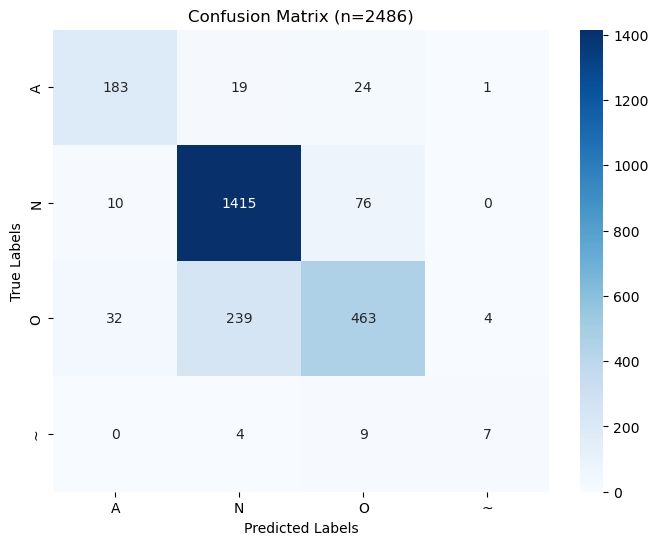

In [10]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])